<a href="https://colab.research.google.com/github/Hussein-Ahmad-94/Encoding_the_loss/blob/main/Three%2BModels%2BStacking_on_combined_loss%2BFeatures_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case 1

----- one feature ----

**Section 1: Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


**Section 2: Load and Preprocess Data**

*Data Loading and Preprocessing:*

Importing necessary libraries, including NumPy, TensorFlow (for deep learning), and pandas for data manipulation.
The dataset is loaded from a CSV file ("train.csv") into a pandas DataFrame. The data contains a "Date" column, which is set as the index.
The data is split into training and testing sets. The testing set consists of the last 20% of the data.

In [ ]:
# Load dataset
df = pd.read_csv("train.csv", parse_dates=["Date"], index_col=[0])

# Train-test split
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

# Scaling
''''Data Scaling: The MinMaxScaler is used to scale the data between 0 and 1.'''
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_1feature = scaler.fit_transform(df_for_training.iloc[:, :1])
df_for_testing_scaled_1feature = scaler.transform(df_for_testing.iloc[:, :1])


In [ ]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

**Section 3: Function for Creating Input and Output Pairs**

In [ ]:
# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


*Input and Output Pairs:*

The **createXY** function is defined to create input and output pairs for training the models. It takes a dataset and a parameter n_past which represents the number of past time steps to use for predicting the next time step.
**Two sets of input and output pairs** are created for training and testing using the training and testing datasets.

**Section 4: Creating Input and Output Pairs for Training and Testing**


In [ ]:
# Creating input and output pairs for training and testing
n_past = 30
trainX_1feature, trainY_1feature = createXY(df_for_training_scaled_1feature, n_past)
testX_1feature, testY_1feature = createXY(df_for_testing_scaled_1feature, n_past)


**Section 5: Define Custom Loss Function**

A custom loss function named custom_loss is defined using Keras backend functions. It calculates the mean squared error between the predicted and true values

In [ ]:
# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss


**Section 6: Build and Compile Models**

In [ ]:
# Build and compile models
model1_1feature = Sequential()
model1_1feature.add(LSTM(64, input_shape=(n_past, 1)))
model1_1feature.add(Dense(1))
model1_1feature.compile(optimizer=Adam(), loss=custom_loss)

model2_1feature = Sequential()
model2_1feature.add(LSTM(64, input_shape=(n_past, 1)))
model2_1feature.add(Dense(1))
model2_1feature.compile(optimizer=Adam(), loss=custom_loss)


**Section 7: Train Models 1 and 2**

Two identical LSTM models (model1 and model2) are created. Each consists of an LSTM layer with 64 units followed by a Dense layer with one unit (for regression).
Both models are compiled using the Adam optimizer and the custom loss function.
The models are trained on the training data (trainX and trainY) for 10 epochs.

In [ ]:
# Train the models
epochs = 10
batch_size = 32

# Model 1 training and validation
history1 = model1_1feature.fit(
    trainX_1feature, trainY_1feature,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

# Model 2 training and validation
history2 = model2_1feature.fit(
    trainX_1feature, trainY_1feature,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


**Section 8: Plot Training and Validation Curves for Models 1 and 2**

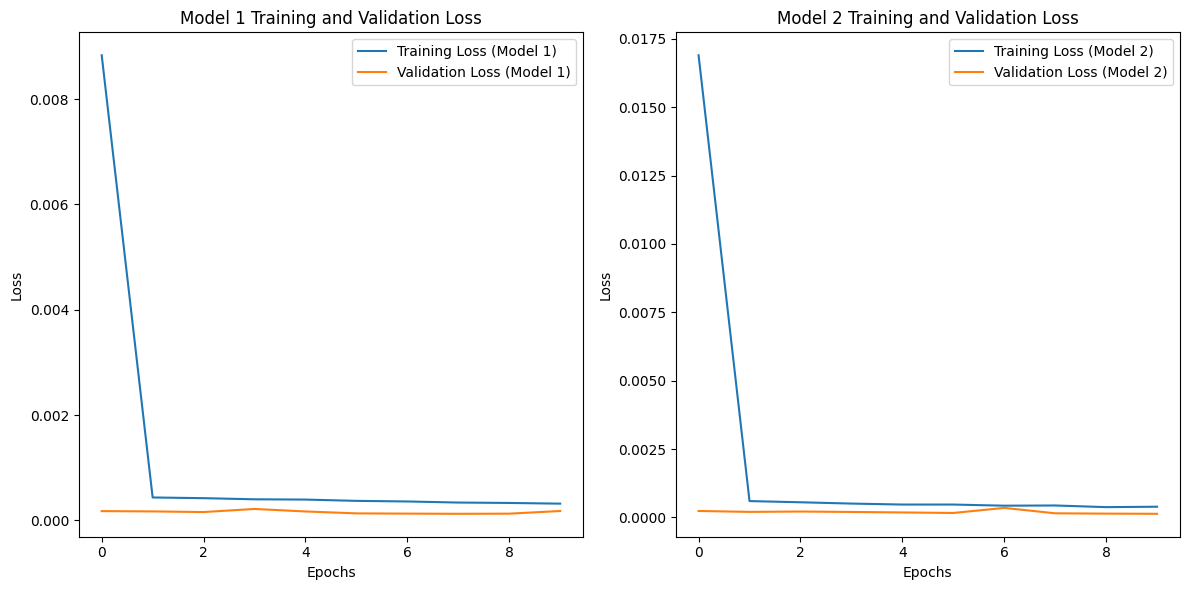

In [ ]:
# Plot training and validation curves for each model separately
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Section 9: Evaluate Models 1 and 2 on Test Data**

Model Evaluation:

The trained models (model1 and model2) are evaluated on the test data (testX and testY), and their individual losses are calculated.

In [ ]:
# Evaluate the models on test data
loss1_1feature = model1_1feature.evaluate(testX_1feature, testY_1feature)
loss2_1feature = model2_1feature.evaluate(testX_1feature, testY_1feature)


32/32 [==============================] - 0s 3ms/step - loss: 1.9400e-04


**Section 10: Combine Losses for Model 3**

The losses from model1 and model2 are averaged to create a combined loss. This combined loss is then used as the target for training the third model.

In [ ]:
# Combine the losses and set as the target for the third model
combined_loss_1feature = (loss1_1feature + loss2_1feature) / 2
y_combined_loss_1feature = np.full((len(testY_1feature), 1), combined_loss_1feature)


**Section 11: Build and Compile Model 3**

In [ ]:
# Build and compile the third LSTM model
model3_1feature = Sequential()
model3_1feature.add(LSTM(64, input_shape=(n_past, 1)))
model3_1feature.add(Dense(1))
model3_1feature.compile(optimizer=Adam(), loss=custom_loss)


**Section 12: Train Model 3**

Another LSTM model (model3) is created, similar to the first two models.
This model is compiled with the Adam optimizer and the custom loss function.
Instead of using the original target (testY), it is trained using the combined loss as the target (y_combined_loss) for 10 epochs.

In [ ]:
# Train the third model using the combined loss as the target
history3 = model3_1feature.fit(
    testX_1feature, y_combined_loss_1feature,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


**Section 13: Plot Training Curves for All Models and Testing Performance**

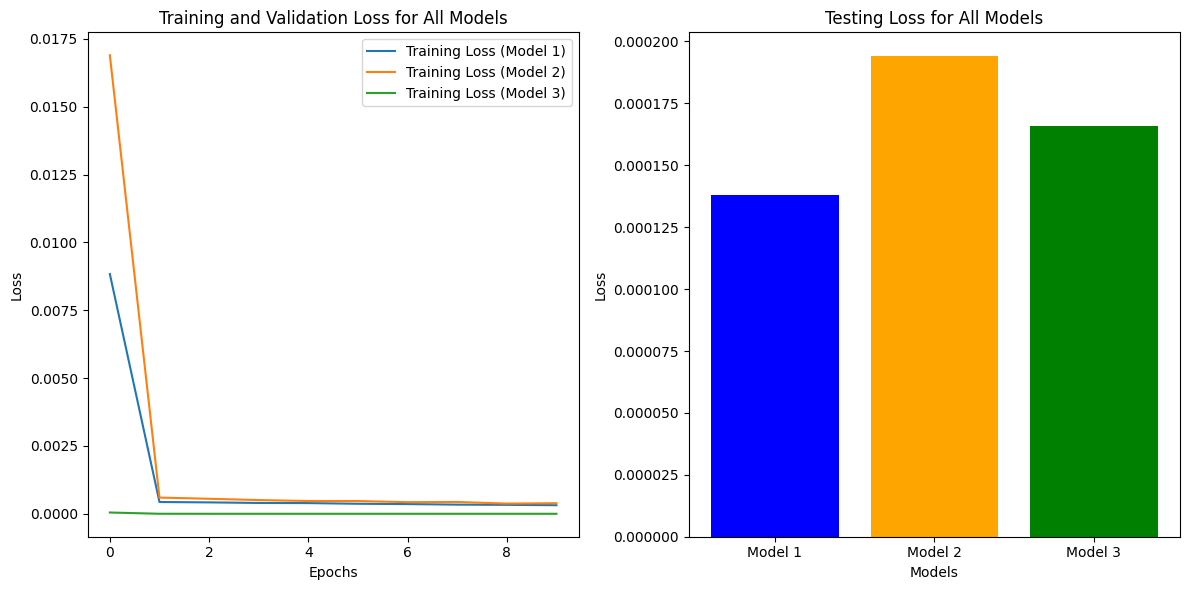

In [ ]:
# Plot training curves for all models on one figure and testing on another figure
plt.figure(figsize=(12, 6))

# Training curves for all models
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
#plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
#plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.plot(history3.history['loss'], label='Training Loss (Model 3)')
#plt.plot(history3.history['val_loss'], label='Validation Loss (Model 3)')
plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing performance
plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2', 'Model 3'], [loss1_1feature, loss2_1feature, combined_loss_1feature], color=['blue', 'orange', 'green'])
plt.title('Testing Loss for All Models')
plt.xlabel('Models')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
# Extract final training and testing loss for each model
final_loss_table = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Final Training Loss': [history1.history['loss'][-1], history2.history['loss'][-1], history3.history['loss'][-1]],
    'Final Testing Loss': [loss1_1feature, loss2_1feature, model3_1feature.evaluate(testX_1feature, y_combined_loss_1feature)]
})

# Display the table
print(final_loss_table)

32/32 [==============================] - 0s 4ms/step - loss: 1.6149e-08
     Model  Final Training Loss  Final Testing Loss
0  Model 1         3.166514e-04        1.379846e-04
1  Model 2         3.908226e-04        1.939989e-04
2  Model 3         2.688574e-08        1.614859e-08


32/32 [==============================] - 0s 6ms/step - loss: 1.6149e-08


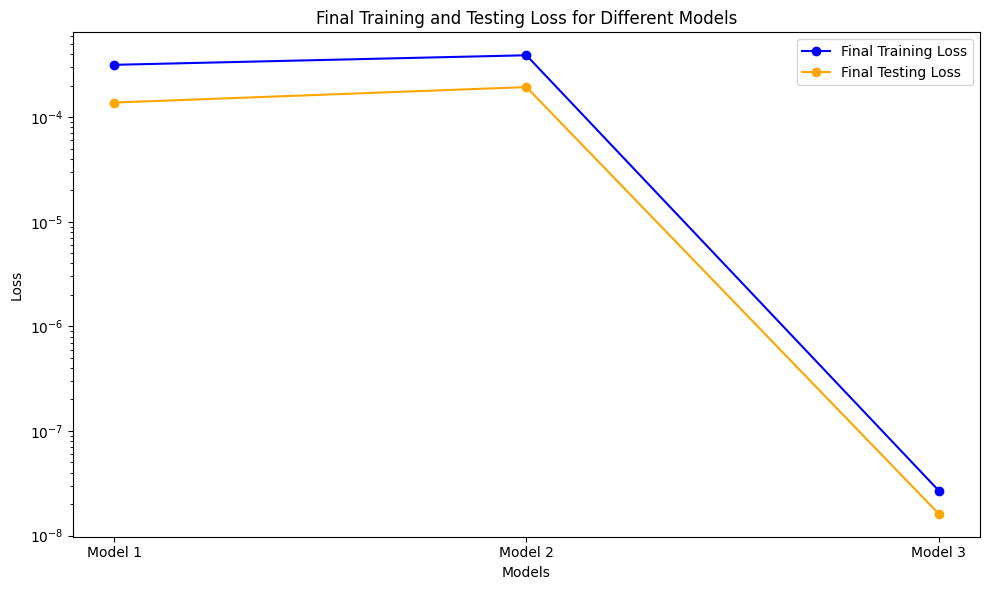

In [ ]:
import matplotlib.pyplot as plt

# Assuming history1, history2, history3 are your training history objects
final_loss_model1 = history1.history['loss'][-1]
final_loss_model2 = history2.history['loss'][-1]
final_loss_model3 = history3.history['loss'][-1]

final_testing_loss_model1 = loss1_1feature
final_testing_loss_model2 = loss2_1feature
final_testing_loss_model3 = model3_1feature.evaluate(testX_1feature, y_combined_loss_1feature)

# Plotting the final training loss
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3], [final_loss_model1, final_loss_model2, final_loss_model3], marker='o', label='Final Training Loss', color='blue')

# Plotting the final testing loss
plt.plot([1, 2, 3], [final_testing_loss_model1, final_testing_loss_model2, final_testing_loss_model3], marker='o', label='Final Testing Loss', color='orange')

plt.title('Final Training and Testing Loss for Different Models')
plt.xlabel('Models')
plt.xticks([1, 2, 3], ['Model 1', 'Model 2', 'Model 3'])
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility of small values

plt.tight_layout()
plt.show()


Implementing an ensemble of LSTM models for time series
forecasting. The first two models are trained independently,
and their losses are combined to train a third model, which is
expected to generalize well on the test data. This ensemble approach aims to improve the overall prediction performance compared to using a single model.






The purpose is to train model3 to minimize the discrepancy between its predictions and the combined loss, which is indicative of the overall performance of the ensemble.

Understanding the Constant Loss (y_combined_loss):
Combined Loss Context:

The constant loss, y_combined_loss, is derived from the average loss of Model1 and Model2 on the test data. This loss represents the overall performance of the ensemble.
Target for Model3:

During training, Model3 attempts to minimize the difference between its predictions and the constant loss (y_combined_loss). In essence, it learns to generate predictions that align with the collective behavior of the ensemble.
Mechanism of Learning:
Backpropagation and Gradients:

Even though the target is constant, the backpropagation algorithm still computes gradients of the loss with respect to the parameters of Model3.
Adjustment of Parameters:

The optimizer (in this case, Adam) utilizes these gradients to adjust the parameters of Model3. The adjustments are made in a way that minimizes the difference between Model3's predictions and the constant loss.
Learning Patterns:

Through this process, Model3 learns to capture patterns and relationships present in the training data that are indicative of the ensemble's collective behavior.
Generalization:

The hope is that by training on the constant loss, Model3 generalizes its learning to unseen data. It adapts its internal parameters to not just mimic the ensemble on the training data but to understand and reproduce the ensemble's approach on new, unseen instances.
Intuition Behind Constant Loss Training:
Mimicking Ensemble Behavior:

The constant loss serves as a guide for Model3 to mimic the behavior of the ensemble. While the loss is constant during each epoch, the model's parameters are adjusted to achieve this mimicry.
Encouraging Ensemble-Like Predictions:

The training process encourages Model3 to make predictions that would result in a loss similar to the ensemble's average loss. This implicitly incorporates the ensemble's insights into Model3's learning.
Learning from Ensemble's Mistakes:

If the ensemble made errors on certain patterns, Model3 learns from those mistakes. It adjusts its parameters to improve predictions in areas where the ensemble may have struggled.

# Case 2

----- two features ----

**Section 1: Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


**Section 2: Load and Preprocess Data**

In [ ]:
# Load dataset
df = pd.read_csv("train.csv", parse_dates=["Date"], index_col=[0])

# Train-test split
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_2features = scaler.fit_transform(df_for_training.iloc[:, :2])
df_for_testing_scaled_2features = scaler.transform(df_for_testing.iloc[:, :2])


**Section 3: Function for Creating Input and Output Pairs**

In [ ]:
# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


**Section 4: Creating Input and Output Pairs for Training and Testing**


In [ ]:
# Creating input and output pairs for training and testing
n_past = 30
trainX_2features, trainY_2features = createXY(df_for_training_scaled_2features, n_past)
testX_2features, testY_2features = createXY(df_for_testing_scaled_2features, n_past)


**Section 5: Define Custom Loss Function**

In [ ]:
# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss


**Section 6: Build and Compile Models**

In [ ]:
# Build and compile models
model1_2features = Sequential()
model1_2features.add(LSTM(64, input_shape=(n_past, 2)))
model1_2features.add(Dense(1))
model1_2features.compile(optimizer=Adam(), loss=custom_loss)

model2_2features = Sequential()
model2_2features.add(LSTM(64, input_shape=(n_past, 2)))
model2_2features.add(Dense(1))
model2_2features.compile(optimizer=Adam(), loss=custom_loss)


In [ ]:
testX_2features.shape

(1011, 30, 2)

**Section 7: Train Models 1 and 2**

In [ ]:
# Train the models
epochs = 10
batch_size = 32

# Model 1 training and validation
history1 = model1_2features.fit(
    trainX_2features, trainY_2features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

# Model 2 training and validation
history2 = model2_2features.fit(
    trainX_2features, trainY_2features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


**Section 8: Plot Training and Validation Curves for Models 1 and 2**

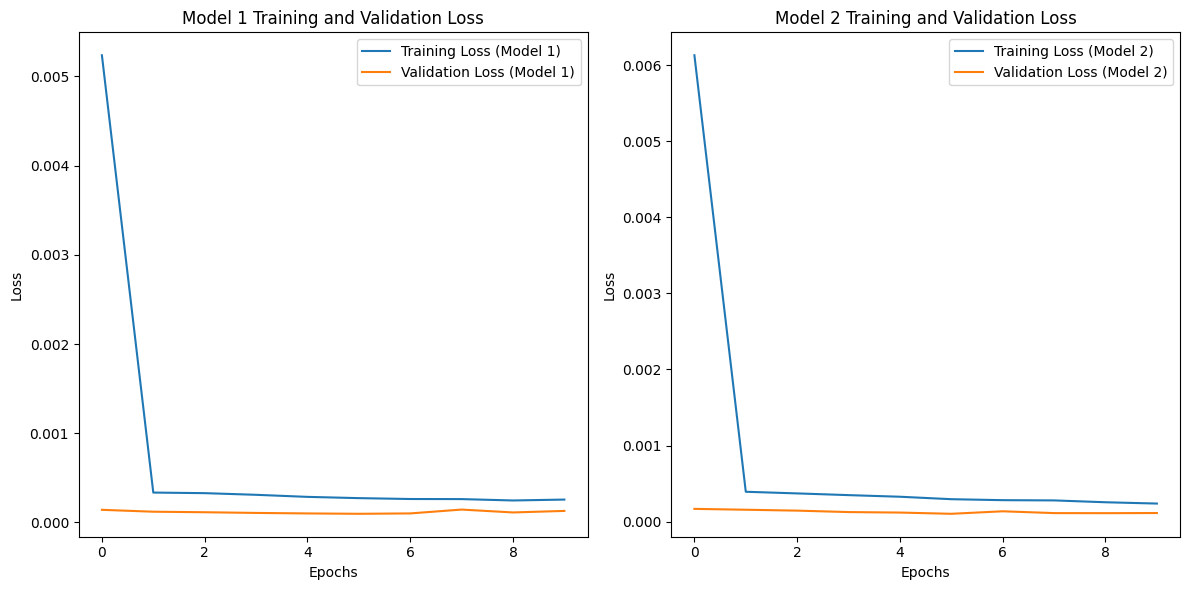

In [ ]:
# Plot training and validation curves for each model separately
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Section 9: Evaluate Models 1 and 2 on Test Data**

In [ ]:
# Evaluate the models on test data
loss1_2features = model1_2features.evaluate(testX_2features, testY_2features)
loss2_2features = model2_2features.evaluate(testX_2features, testY_2features)


32/32 [==============================] - 0s 4ms/step - loss: 1.2833e-04


**Section 10: Combine Losses for Model 3**

In [ ]:
# Combine the losses and set as the target for the third model
combined_loss_2features = (loss1_2features + loss2_2features) / 2
y_combined_loss_2features = np.full((len(testY_2features), 1), combined_loss_2features)


In [ ]:
y_combined_loss_2features.shape

(1011, 1)

**Section 11: Build and Compile Model 3**

In [ ]:
# Build and compile the third LSTM model
model3_2features = Sequential()
model3_2features.add(LSTM(64, input_shape=(n_past, 2)))
model3_2features.add(Dense(1))
model3_2features.compile(optimizer=Adam(), loss=custom_loss)


**Section 12: Train Model 3**

In [ ]:
# Train the third model using the combined loss as the target
history3 = model3_2features.fit(
    testX_2features, y_combined_loss_2features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


In [ ]:
testX_2features.shape

(1011, 30, 2)

**Section 13: Plot Training Curves for All Models and Testing Performance**

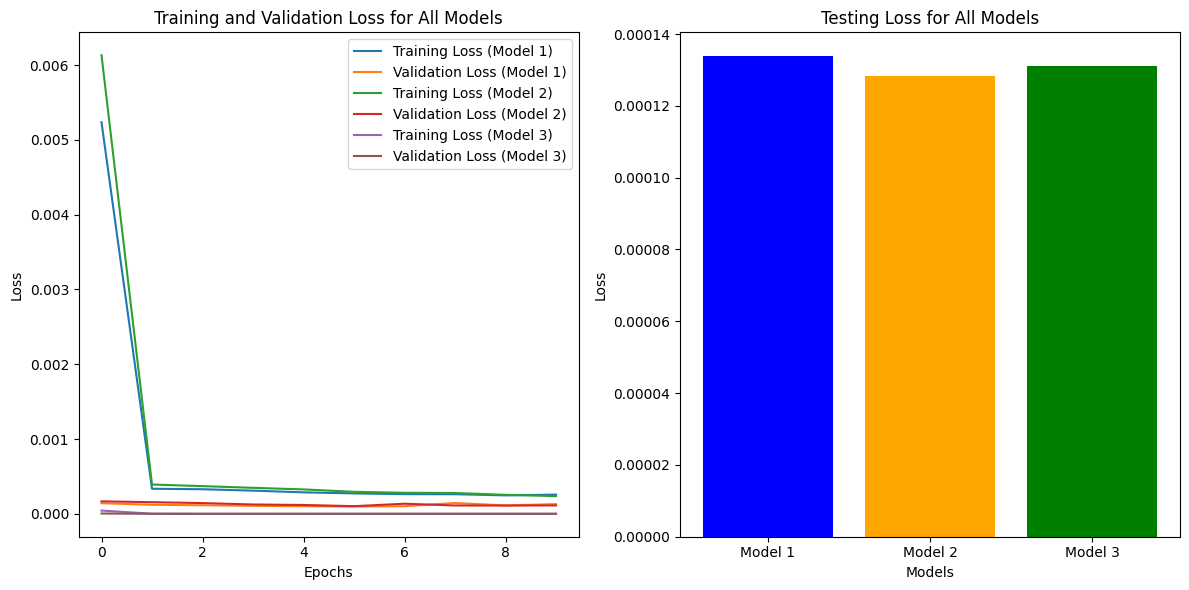

In [ ]:
# Plot training curves for all models on one figure and testing on another figure
plt.figure(figsize=(12, 6))

# Training curves for all models
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.plot(history3.history['loss'], label='Training Loss (Model 3)')
plt.plot(history3.history['val_loss'], label='Validation Loss (Model 3)')
plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing performance
plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2', 'Model 3'], [loss1_2features, loss2_2features, combined_loss_2features], color=['blue', 'orange', 'green'])
plt.title('Testing Loss for All Models')
plt.xlabel('Models')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Section 13: Extract Final Training and Testing Loss for Each Model and Display Table**

In [ ]:
# Extract final training and testing loss for each model
final_loss_table = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Final Training Loss': [history1.history['loss'][-1], history2.history['loss'][-1], history3.history['loss'][-1]],
    'Final Testing Loss': [loss1_2features, loss2_2features, model3_2features.evaluate(testX_2features, y_combined_loss_2features)]
})

# Display the table
print(final_loss_table)


32/32 [==============================] - 0s 4ms/step - loss: 1.2873e-08
     Model  Final Training Loss  Final Testing Loss
0  Model 1         2.563856e-04        1.337970e-04
1  Model 2         2.364847e-04        1.283322e-04
2  Model 3         1.300391e-08        1.287275e-08


32/32 [==============================] - 0s 3ms/step - loss: 1.6149e-08


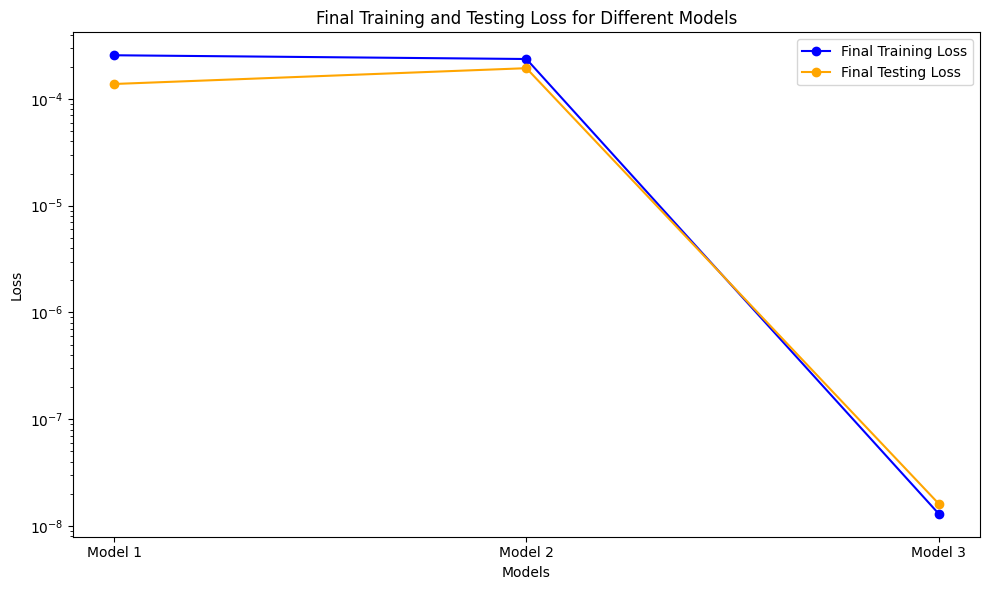

In [ ]:
import matplotlib.pyplot as plt

# Assuming history1, history2, history3 are your training history objects
final_loss_model1 = history1.history['loss'][-1]
final_loss_model2 = history2.history['loss'][-1]
final_loss_model3 = history3.history['loss'][-1]

final_testing_loss_model1 = loss1_1feature
final_testing_loss_model2 = loss2_1feature
final_testing_loss_model3 = model3_1feature.evaluate(testX_1feature, y_combined_loss_1feature)

# Plotting the final training loss
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3], [final_loss_model1, final_loss_model2, final_loss_model3], marker='o', label='Final Training Loss', color='blue')

# Plotting the final testing loss
plt.plot([1, 2, 3], [final_testing_loss_model1, final_testing_loss_model2, final_testing_loss_model3], marker='o', label='Final Testing Loss', color='orange')

plt.title('Final Training and Testing Loss for Different Models')
plt.xlabel('Models')
plt.xticks([1, 2, 3], ['Model 1', 'Model 2', 'Model 3'])
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility of small values

plt.tight_layout()
plt.show()


# Case 3

----- three features -----

**Section 1: Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


**Section 2: Load and Preprocess Data**

In [ ]:
# Load dataset
df = pd.read_csv("train.csv", parse_dates=["Date"], index_col=[0])

# Train-test split
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_3features = scaler.fit_transform(df_for_training.iloc[:, :3])
df_for_testing_scaled_3features = scaler.transform(df_for_testing.iloc[:, :3])


**Section 3: Function for Creating Input and Output Pairs**

In [ ]:
# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


**Section 4: Creating Input and Output Pairs for Training and Testing**


In [ ]:
# Creating input and output pairs for training and testing
n_past = 30
trainX_3features, trainY_3features = createXY(df_for_training_scaled_3features, n_past)
testX_3features, testY_3features = createXY(df_for_testing_scaled_3features, n_past)


**Section 5: Define Custom Loss Function**

In [ ]:
# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss


**Section 6: Build and Compile Models**

In [ ]:
# Build and compile models
model1_3features = Sequential()
model1_3features.add(LSTM(64, input_shape=(n_past, 3)))
model1_3features.add(Dense(1))
model1_3features.compile(optimizer=Adam(), loss=custom_loss)

model2_3features = Sequential()
model2_3features.add(LSTM(64, input_shape=(n_past, 3)))
model2_3features.add(Dense(1))
model2_3features.compile(optimizer=Adam(), loss=custom_loss)


**Section 7: Train Models 1 and 2**

In [ ]:
# Train the models
epochs = 10
batch_size = 32

# Model 1 training and validation
history1 = model1_3features.fit(
    trainX_3features, trainY_3features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

# Model 2 training and validation
history2 = model2_3features.fit(
    trainX_3features, trainY_3features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


**Section 8: Plot Training and Validation Curves for Models 1 and 2**

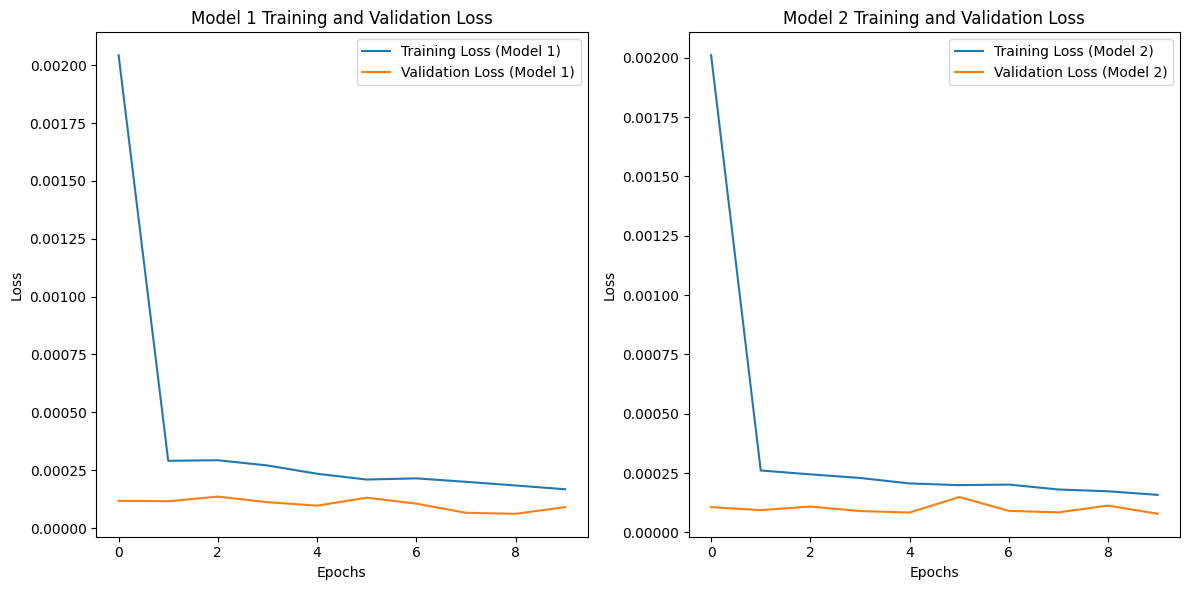

In [ ]:
# Plot training and validation curves for each model separately
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Section 9: Evaluate Models 1 and 2 on Test Data**

In [ ]:
# Evaluate the models on test data
loss1_3features = model1_3features.evaluate(testX_3features, testY_3features)
loss2_3features = model2_3features.evaluate(testX_3features, testY_3features)


32/32 [==============================] - 0s 4ms/step - loss: 9.2730e-05


**Section 10: Combine Losses for Model 3**

In [ ]:
# Combine the losses and set as the target for the third model
combined_loss_3features = (loss1_3features + loss2_3features) / 2
y_combined_loss_3features = np.full((len(testY_3features), 1), combined_loss_3features)


**Section 11: Build and Compile Model 3**

In [ ]:
# Build and compile the third LSTM model
model3_3features = Sequential()
model3_3features.add(LSTM(64, input_shape=(n_past, 3)))
model3_3features.add(Dense(1))
model3_3features.compile(optimizer=Adam(), loss=custom_loss)


**Section 12: Train Model 3**

In [ ]:
# Train the third model using the combined loss as the target
history3 = model3_3features.fit(
    testX_3features, y_combined_loss_3features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


**Section 13: Plot Training Curves for All Models and Testing Performance**

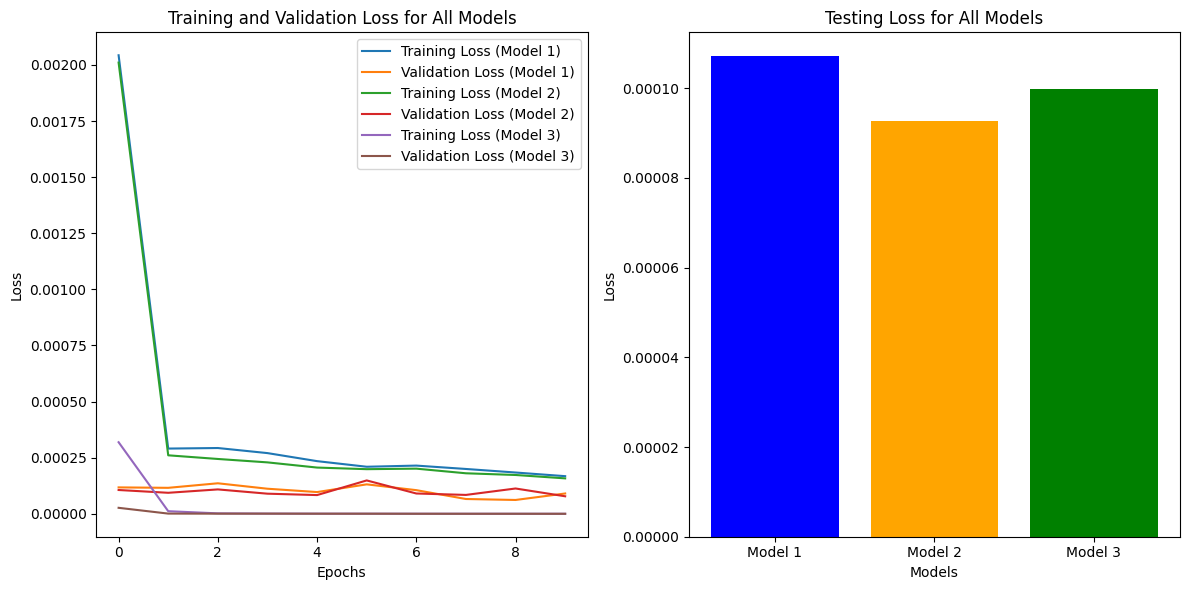

In [ ]:
# Plot training curves for all models on one figure and testing on another figure
plt.figure(figsize=(12, 6))

# Training curves for all models
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.plot(history3.history['loss'], label='Training Loss (Model 3)')
plt.plot(history3.history['val_loss'], label='Validation Loss (Model 3)')
plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing performance
plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2', 'Model 3'], [loss1_3features, loss2_3features, combined_loss_3features], color=['blue', 'orange', 'green'])
plt.title('Testing Loss for All Models')
plt.xlabel('Models')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Section 13: Extract Final Training and Testing Loss for Each Model and Display Table**

In [ ]:
# Extract final training and testing loss for each model
final_loss_table = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Final Training Loss': [history1.history['loss'][-1], history2.history['loss'][-1], history3.history['loss'][-1]],
    'Final Testing Loss': [loss1_3features, loss2_3features, model3_3features.evaluate(testX_3features, y_combined_loss_3features)]
})

# Display the table
print(final_loss_table)


32/32 [==============================] - 0s 4ms/step - loss: 1.3927e-07
     Model  Final Training Loss  Final Testing Loss
0  Model 1         1.676855e-04        1.070991e-04
1  Model 2         1.578674e-04        9.273020e-05
2  Model 3         1.714375e-07        1.392690e-07


32/32 [==============================] - 0s 4ms/step - loss: 1.6149e-08


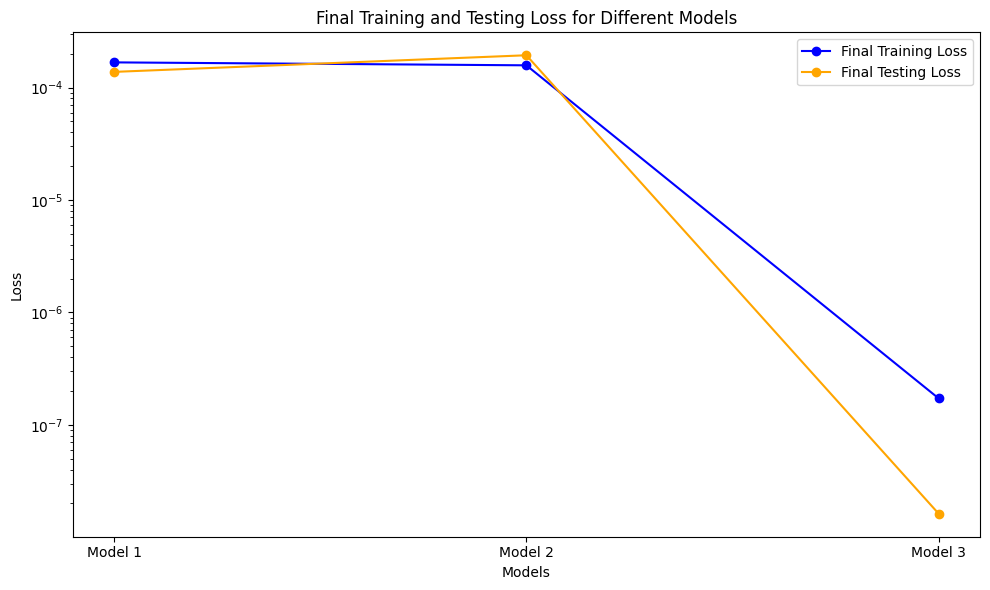

In [ ]:
import matplotlib.pyplot as plt

# Assuming history1, history2, history3 are your training history objects
final_loss_model1 = history1.history['loss'][-1]
final_loss_model2 = history2.history['loss'][-1]
final_loss_model3 = history3.history['loss'][-1]

final_testing_loss_model1 = loss1_1feature
final_testing_loss_model2 = loss2_1feature
final_testing_loss_model3 = model3_1feature.evaluate(testX_1feature, y_combined_loss_1feature)

# Plotting the final training loss
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3], [final_loss_model1, final_loss_model2, final_loss_model3], marker='o', label='Final Training Loss', color='blue')

# Plotting the final testing loss
plt.plot([1, 2, 3], [final_testing_loss_model1, final_testing_loss_model2, final_testing_loss_model3], marker='o', label='Final Testing Loss', color='orange')

plt.title('Final Training and Testing Loss for Different Models')
plt.xlabel('Models')
plt.xticks([1, 2, 3], ['Model 1', 'Model 2', 'Model 3'])
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility of small values

plt.tight_layout()
plt.show()


# Case 4

---- four features ----

**Section 1: Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


**Section 2: Load and Preprocess Data**

In [ ]:
# Load dataset
df = pd.read_csv("train.csv", parse_dates=["Date"], index_col=[0])

# Train-test split
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_4features = scaler.fit_transform(df_for_training.iloc[:, :4])
df_for_testing_scaled_4features = scaler.transform(df_for_testing.iloc[:, :4])


**Section 3: Function for Creating Input and Output Pairs**

In [ ]:
# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

**Section 4: Creating Input and Output Pairs for Training and Testing**


In [ ]:
# Creating input and output pairs for training and testing
n_past = 30
trainX_4features, trainY_4features = createXY(df_for_training_scaled_4features, n_past)
testX_4features, testY_4features = createXY(df_for_testing_scaled_4features, n_past)


**Section 5: Define Custom Loss Function**

In [ ]:
# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

**Section 6: Build and Compile Models**

In [ ]:
# Build and compile two LSTM models
model1_4features = Sequential()
model1_4features.add(LSTM(64, input_shape=(n_past, 4)))
model1_4features.add(Dense(1))
model1_4features.compile(optimizer=Adam(), loss=custom_loss)

model2_4features = Sequential()
model2_4features.add(LSTM(64, input_shape=(n_past, 4)))
model2_4features.add(Dense(1))
model2_4features.compile(optimizer=Adam(), loss=custom_loss)


**Section 7: Train Models 1 and 2**

In [ ]:
# Train the models
epochs = 10
batch_size = 32

# Model 1 training and validation
history1 = model1_4features.fit(
    trainX_4features, trainY_4features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

# Model 2 training and validation
history2 = model2_4features.fit(
    trainX_4features, trainY_4features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

**Section 8: Plot Training and Validation Curves for Models 1 and 2**

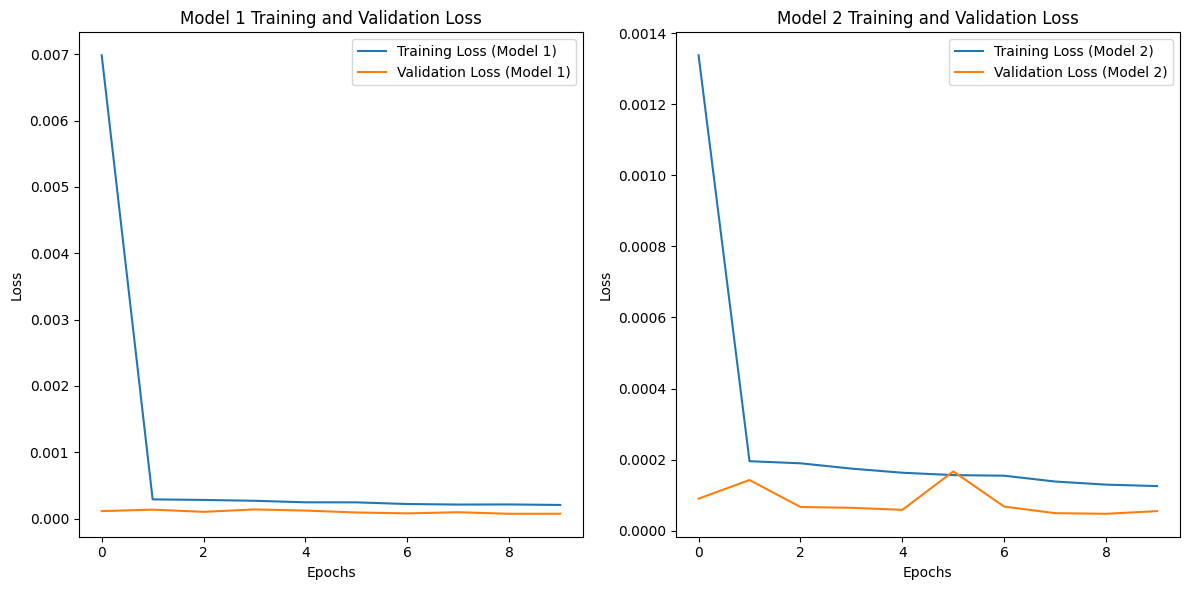

In [ ]:
# Plot training and validation curves for each model separately
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Section 9: Evaluate Models 1 and 2 on Test Data**

In [ ]:
# Evaluate the models on test data
loss1_4features = model1_4features.evaluate(testX_4features, testY_4features)
loss2_4features = model2_4features.evaluate(testX_4features, testY_4features)


32/32 [==============================] - 0s 4ms/step - loss: 5.8283e-05


**Section 10: Combine Losses for Model 3**

In [ ]:
# Combine the losses and set as the target for the third model
combined_loss_4features = (loss1_4features + loss2_4features) / 2
y_combined_loss_4features = np.full((len(testY_4features), 1), combined_loss_4features)

**Section 11: Build and Compile Model 3**

In [ ]:
# Build and compile the third LSTM model
model3_4features = Sequential()
model3_4features.add(LSTM(64, input_shape=(n_past, 4)))
model3_4features.add(Dense(1))
model3_4features.compile(optimizer=Adam(), loss=custom_loss)

**Section 12: Train Model 3**

In [ ]:
# Train the third model using the combined loss as the target
history3 = model3_4features.fit(
    testX_4features, y_combined_loss_4features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

**Section 13: Plot Training Curves for All Models and Testing Performance**

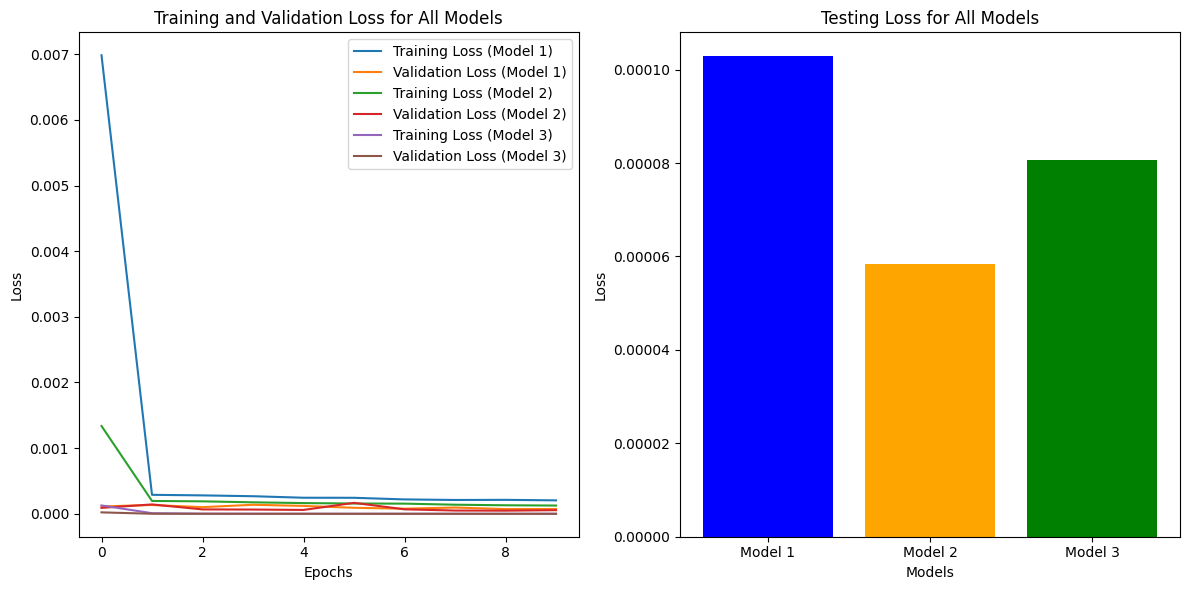

In [ ]:
# Plot training curves for all models on one figure and testing on another figure
plt.figure(figsize=(12, 6))

# Training curves for all models
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.plot(history3.history['loss'], label='Training Loss (Model 3)')
plt.plot(history3.history['val_loss'], label='Validation Loss (Model 3)')
plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing performance
plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2', 'Model 3'], [loss1_4features, loss2_4features, combined_loss_4features], color=['blue', 'orange', 'green'])
plt.title('Testing Loss for All Models')
plt.xlabel('Models')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Section 13: Extract Final Training and Testing Loss for Each Model and Display Table**

In [ ]:
# Extract final training and testing loss for each model
final_loss_table = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Final Training Loss': [history1.history['loss'][-1], history2.history['loss'][-1], history3.history['loss'][-1]],
    'Final Testing Loss': [loss1_4features, loss2_4features, model3_4features.evaluate(testX_4features, y_combined_loss_4features)]
})

# Display the table
print(final_loss_table)

32/32 [==============================] - 0s 4ms/step - loss: 5.7839e-07
     Model  Final Training Loss  Final Testing Loss
0  Model 1         2.049053e-04        1.028452e-04
1  Model 2         1.259029e-04        5.828256e-05
2  Model 3         3.557825e-07        5.783920e-07


32/32 [==============================] - 0s 3ms/step - loss: 1.6149e-08


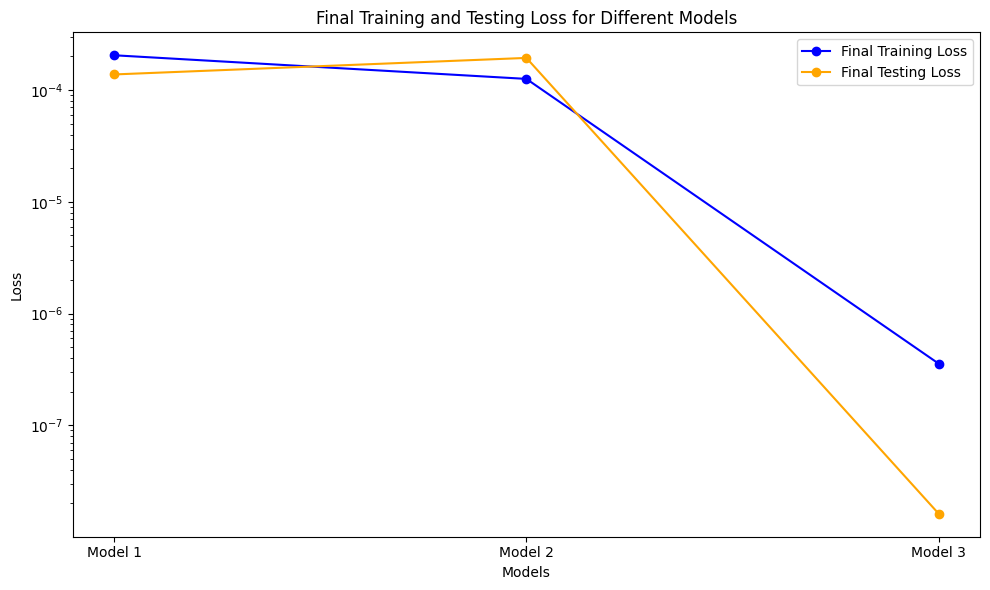

In [ ]:
import matplotlib.pyplot as plt

# Assuming history1, history2, history3 are your training history objects
final_loss_model1 = history1.history['loss'][-1]
final_loss_model2 = history2.history['loss'][-1]
final_loss_model3 = history3.history['loss'][-1]

final_testing_loss_model1 = loss1_1feature
final_testing_loss_model2 = loss2_1feature
final_testing_loss_model3 = model3_1feature.evaluate(testX_1feature, y_combined_loss_1feature)

# Plotting the final training loss
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3], [final_loss_model1, final_loss_model2, final_loss_model3], marker='o', label='Final Training Loss', color='blue')

# Plotting the final testing loss
plt.plot([1, 2, 3], [final_testing_loss_model1, final_testing_loss_model2, final_testing_loss_model3], marker='o', label='Final Testing Loss', color='orange')

plt.title('Final Training and Testing Loss for Different Models')
plt.xlabel('Models')
plt.xticks([1, 2, 3], ['Model 1', 'Model 2', 'Model 3'])
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility of small values

plt.tight_layout()
plt.show()


# Case 5

---- five features ----

**Section 1: Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


**Section 2: Load and Preprocess Data**

In [ ]:
# Load dataset
df = pd.read_csv("train.csv", parse_dates=["Date"], index_col=[0])

# Train-test split
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled_5features = scaler.fit_transform(df_for_training.iloc[:, :5])
df_for_testing_scaled_5features = scaler.transform(df_for_testing.iloc[:, :5])


**Section 3: Function for Creating Input and Output Pairs**

In [ ]:
# Function to create input and output pairs
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)


**Section 4: Creating Input and Output Pairs for Training and Testing**


In [ ]:
# Creating input and output pairs for training and testing
n_past = 30
trainX_5features, trainY_5features = createXY(df_for_training_scaled_5features, n_past)
testX_5features, testY_5features = createXY(df_for_testing_scaled_5features, n_past)

**Section 5: Define Custom Loss Function**

In [ ]:
# Define custom loss function
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

**Section 6: Build and Compile Models**

In [ ]:
# Build and compile two LSTM models
model1_5features = Sequential()
model1_5features.add(LSTM(64, input_shape=(n_past, 5)))
model1_5features.add(Dense(1))
model1_5features.compile(optimizer=Adam(), loss=custom_loss)

model2_5features = Sequential()
model2_5features.add(LSTM(64, input_shape=(n_past, 5)))
model2_5features.add(Dense(1))
model2_5features.compile(optimizer=Adam(), loss=custom_loss)

**Section 7: Train Models 1 and 2**

In [ ]:
# Train the models
epochs = 10
batch_size = 32

# Model 1 training and validation
history1 = model1_5features.fit(
    trainX_5features, trainY_5features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

# Model 2 training and validation
history2 = model2_5features.fit(
    trainX_5features, trainY_5features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)


**Section 8: Plot Training and Validation Curves for Models 1 and 2**

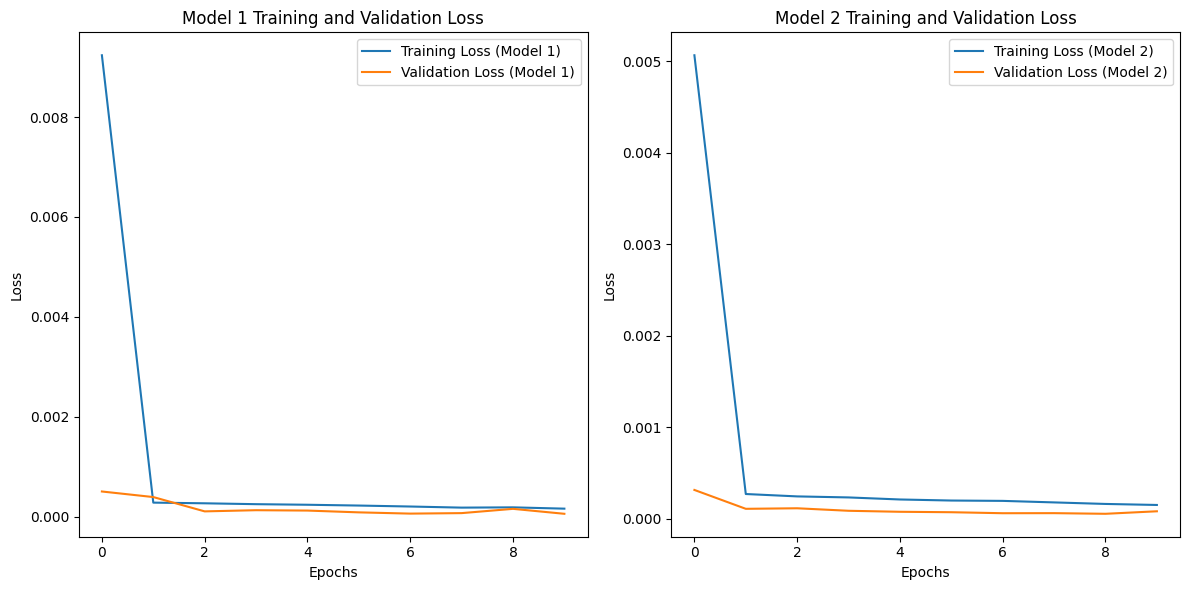

In [ ]:
# Plot training and validation curves for each model separately
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Section 9: Evaluate Models 1 and 2 on Test Data**

In [ ]:
# Evaluate the models on test data
loss1_5features = model1_5features.evaluate(testX_5features, testY_5features)
loss2_5features = model2_5features.evaluate(testX_5features, testY_5features)

32/32 [==============================] - 0s 4ms/step - loss: 1.3099e-04


**Section 10: Combine Losses for Model 3**

In [ ]:
# Combine the losses and set as the target for the third model
combined_loss_5features = (loss1_5features + loss2_5features) / 2
y_combined_loss_5features = np.full((len(testY_5features), 1), combined_loss_5features)

**Section 11: Build and Compile Model 3**

In [ ]:
# Build and compile the third LSTM model
model3_5features = Sequential()
model3_5features.add(LSTM(64, input_shape=(n_past, 5)))
model3_5features.add(Dense(1))
model3_5features.compile(optimizer=Adam(), loss=custom_loss)


**Section 12: Train Model 3**

In [ ]:
# Train the third model using the combined loss as the target
history3 = model3_5features.fit(
    testX_5features, y_combined_loss_5features,
    epochs=epochs, batch_size=batch_size,
    validation_split=0.1, verbose=0
)

**Section 13: Plot Training Curves for All Models and Testing Performance**

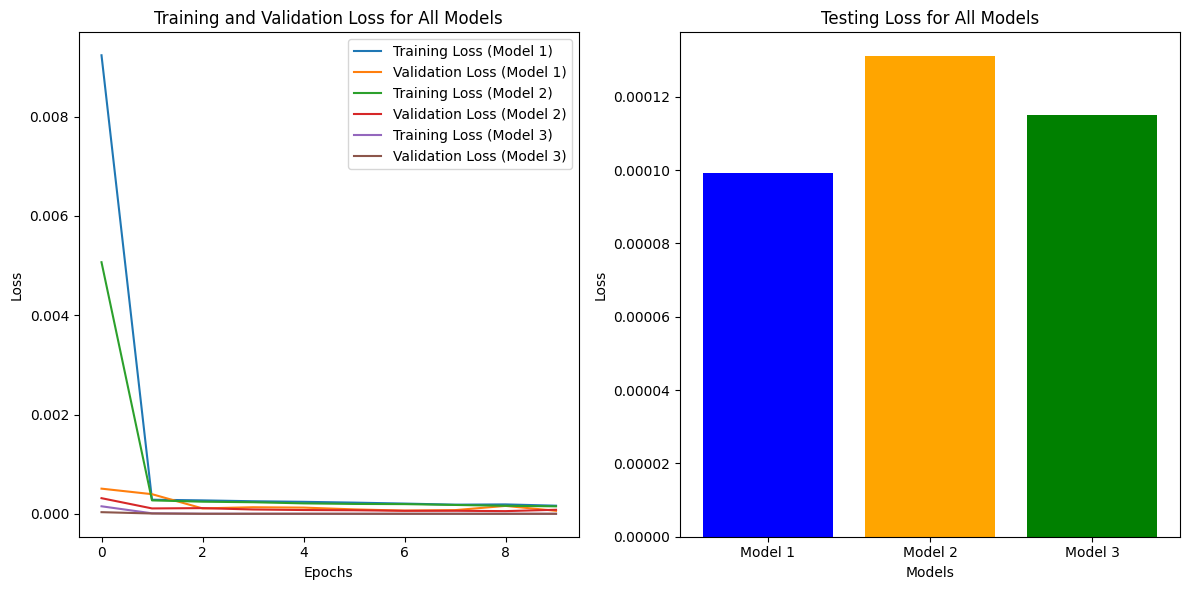

In [ ]:
# Plot training curves for all models on one figure and testing on another figure
plt.figure(figsize=(12, 6))

# Training curves for all models
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss (Model 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1)')
plt.plot(history2.history['loss'], label='Training Loss (Model 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2)')
plt.plot(history3.history['loss'], label='Training Loss (Model 3)')
plt.plot(history3.history['val_loss'], label='Validation Loss (Model 3)')
plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing performance
plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2', 'Model 3'], [loss1_5features, loss2_5features, combined_loss_5features], color=['blue', 'orange', 'green'])
plt.title('Testing Loss for All Models')
plt.xlabel('Models')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Section 13: Extract Final Training and Testing Loss for Each Model and Display Table**

In [ ]:
# Extract final training and testing loss for each model
final_loss_table = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Final Training Loss': [history1.history['loss'][-1], history2.history['loss'][-1], history3.history['loss'][-1]],
    'Final Testing Loss': [loss1_5features, loss2_5features, model3_5features.evaluate(testX_5features, y_combined_loss_5features)]
})

# Display the table
print(final_loss_table)


32/32 [==============================] - 0s 4ms/step - loss: 3.0293e-07
     Model  Final Training Loss  Final Testing Loss
0  Model 1         1.632653e-04        9.905043e-05
1  Model 2         1.503985e-04        1.309937e-04
2  Model 3         3.758218e-07        3.029331e-07


32/32 [==============================] - 0s 4ms/step - loss: 1.6149e-08


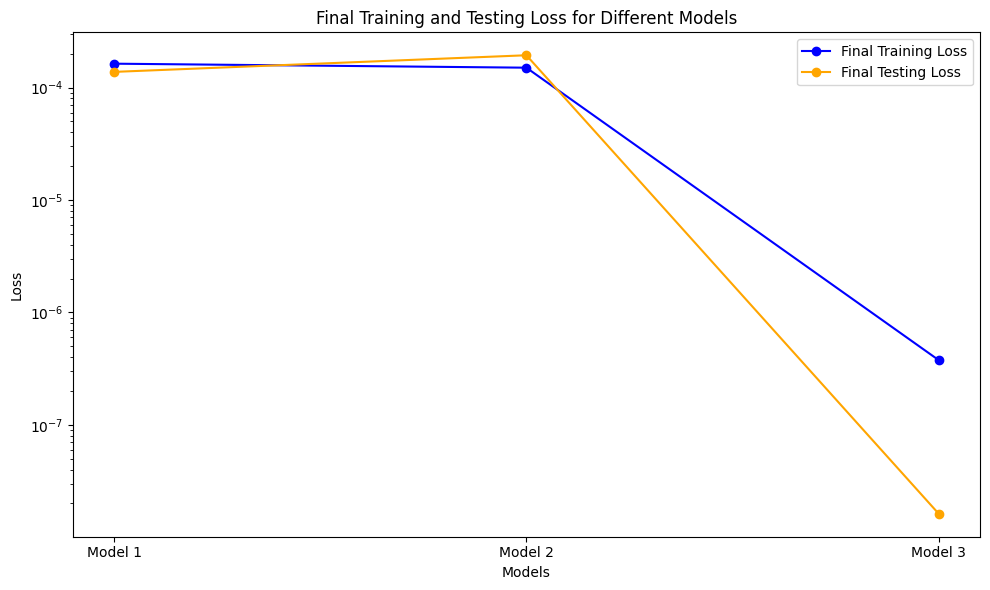

In [ ]:
import matplotlib.pyplot as plt

# Assuming history1, history2, history3 are your training history objects
final_loss_model1 = history1.history['loss'][-1]
final_loss_model2 = history2.history['loss'][-1]
final_loss_model3 = history3.history['loss'][-1]

final_testing_loss_model1 = loss1_1feature
final_testing_loss_model2 = loss2_1feature
final_testing_loss_model3 = model3_1feature.evaluate(testX_1feature, y_combined_loss_1feature)

# Plotting the final training loss
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3], [final_loss_model1, final_loss_model2, final_loss_model3], marker='o', label='Final Training Loss', color='blue')

# Plotting the final testing loss
plt.plot([1, 2, 3], [final_testing_loss_model1, final_testing_loss_model2, final_testing_loss_model3], marker='o', label='Final Testing Loss', color='orange')

plt.title('Final Training and Testing Loss for Different Models')
plt.xlabel('Models')
plt.xticks([1, 2, 3], ['Model 1', 'Model 2', 'Model 3'])
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility of small values

plt.tight_layout()
plt.show()


**Section 7: Train Models 1 and 2**

**Section 8: Plot Training and Validation Curves for Models 1 and 2**

**Section 9: Evaluate Models 1 and 2 on Test Data**

**Section 10: Combine Losses for Model 3**

**Section 11: Build and Compile Model 3**